<a href="https://colab.research.google.com/github/LazaroR-u/EQNN_for_HEP/blob/main/hep_data/Quark_Gluon_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quark Gluon dataset Preprocessing

In this Jupyter Notebook we load the Quark-Gluon dataset, perform a quick data analysis and process to obtain reduced Q-G datasets per channel using different methods to reduce images like bilinear, Gaussian, Lanczos3, Lanczos5, and area.

The file consists of 4 datasets:

- X_jets: energy deposited in the ECAL, HCAL and tracker. (image of 3 channels)
- m0: mass (a number)
- pt: transversed momentum (a number)
- y: labels 0 or 1 for gluon and quark, respectively. (a label)


We use the dataset described in Andrews et al., which was derived from simulated data for QCD dijet production available on the **CERN CMS Open Data Portal.**

Events were generated and hadronized with the PYTHIA6 Monte Carlo event generator using the Z2∗ tune, which accounts for the difference in the hadronization patterns of quarks and gluons.


We are using the dataset of "X_jets" consisting of 139 306 samples with 3-channel of 125 × 125 images, with half representing quarks and the other half gluons. Each of the three channels in the images corresponds to a specific component of the Compact Muon Solenoid (CMS) detector [53]:

- the inner tracking system (Tracks), which identifies charged particle tracks;
- the electromagnetic
calorimeter (ECAL), which captures energy deposits from electromagnetic particles;
- and the hadronic calorimeter (HCAL), which detects energy deposits from hadrons.

## import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors

## load raw data

In [2]:
f = h5py.File("/content/quark-gluon_test-set_n139306.hdf5","r")

There are three files:
- f : ~140000 samples
- f_train: ~800000 samples
- f_val: 10000 samples

Here, we are using only the f dataset with almost 140 000 samples

In [3]:
f.keys()

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>

In [4]:
x_red = f.get('X_jets')
y_red = f.get('y')
x_red.shape, y_red.shape

((139306, 125, 125, 3), (139306,))

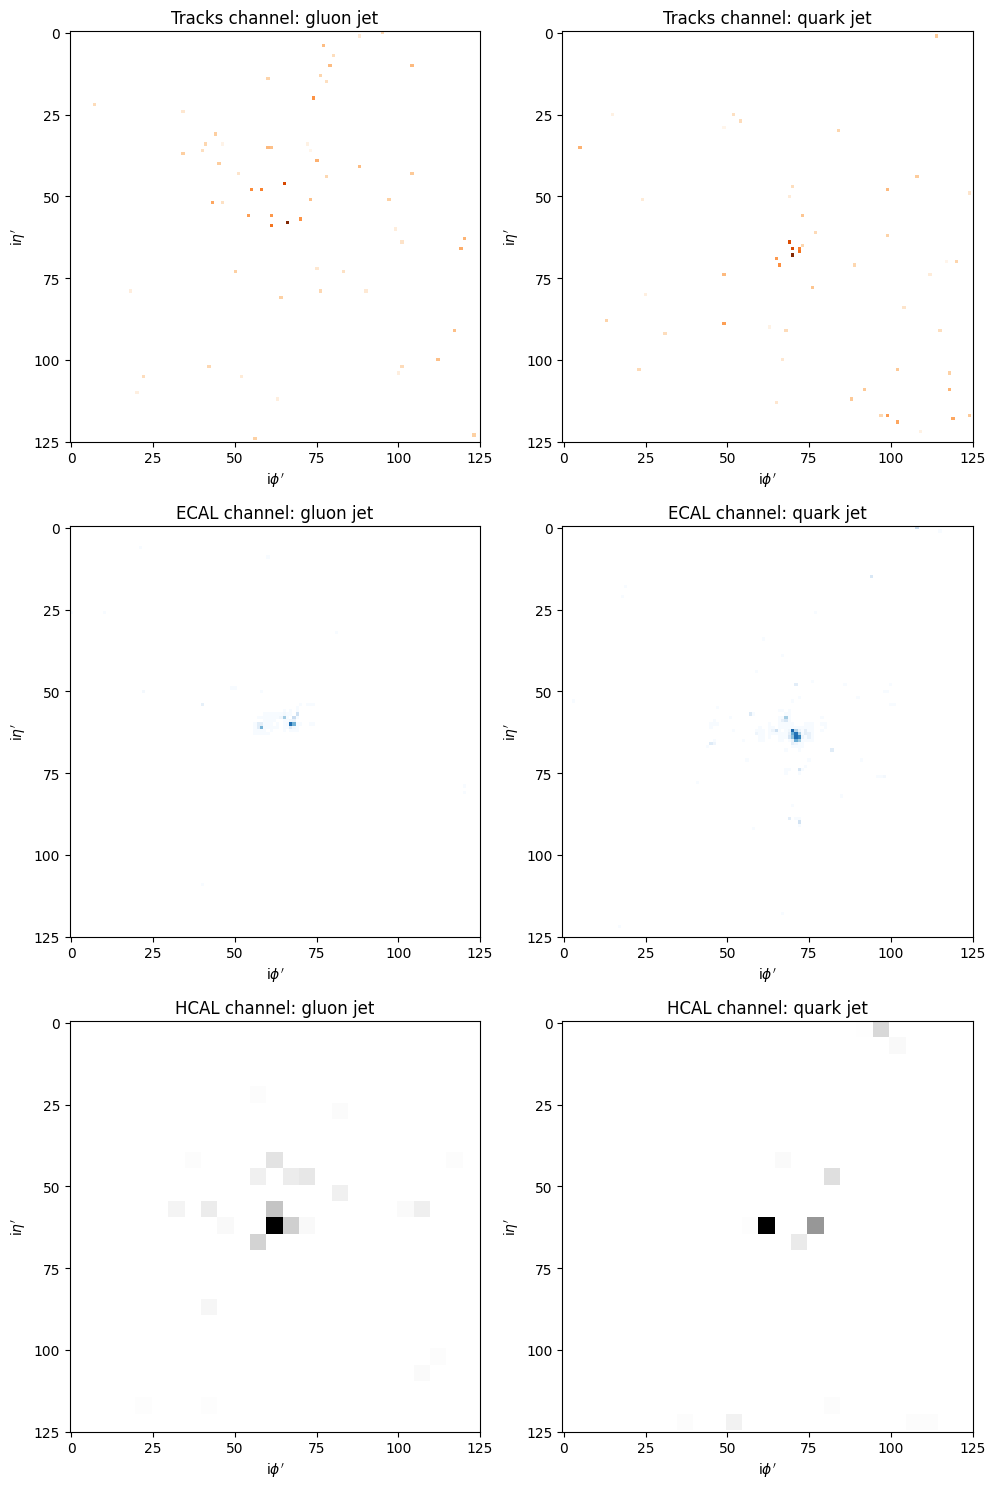

In [5]:
n = 2

jets_gluon = x_red[:10][np.array(y_red[:10]) == 0]
jets_quark = x_red[:10][np.array(y_red[:10]) == 1]

# Define a LogNorm for logarithmic scaling
norm = mcolors.LogNorm()

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# Titles for each subplot
titles_gluon = ["Tracks channel: gluon jet", "ECAL channel: gluon jet", "HCAL channel: gluon jet"]
titles_quark = ["Tracks channel: quark jet", "ECAL channel: quark jet", "HCAL channel: quark jet"]
cmaps = ["Oranges", "Blues", "Greys"]
norms = [norm, norm, None]


# Plot gluon images
for i in range(3):
    axs[i, 0].imshow(jets_gluon[n, :, :, i], cmap=cmaps[i], norm=norms[i])
    axs[i, 0].set_title(titles_gluon[i])
    axs[i, 0].set_xticks(np.arange(0, 126, 25))
    axs[i, 0].set_yticks(np.arange(0, 126, 25))

# Plot quark images
for i in range(3):
    axs[i, 1].imshow(jets_quark[n, :, :, i], cmap=cmaps[i], norm=norms[i])
    axs[i, 1].set_title(titles_quark[i])
    axs[i, 1].set_xticks(np.arange(0, 126, 25))
    axs[i, 1].set_yticks(np.arange(0, 126, 25))


for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")


# Improve layout
plt.tight_layout()
plt.show()

## divide into dataset per channel

visualization of the main intensity per pixel for each channel.

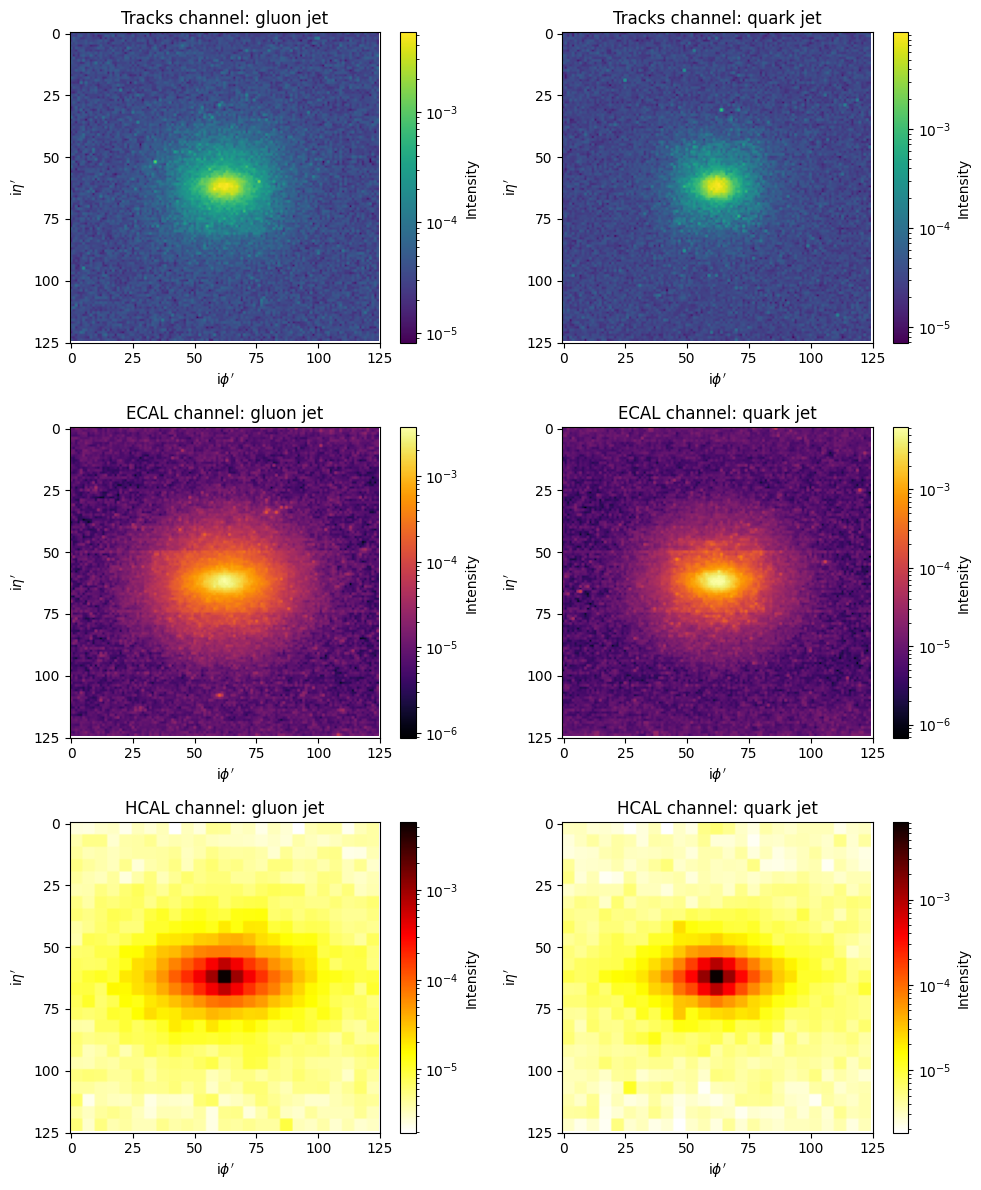

In [67]:
n_sample = 10000

# Calculate the average for each class
gluon_avg = np.mean(x_red[:n_sample][y_red[:n_sample] == 0], axis=0)
quark_avg = np.mean(x_red[:n_sample][y_red[:n_sample] == 1], axis=0)


# Titles for each subplot
titles_gluon = ["Tracks channel: gluon jet", "ECAL channel: gluon jet", "HCAL channel: gluon jet"]
titles_quark = ["Tracks channel: quark jet", "ECAL channel: quark jet", "HCAL channel: quark jet"]
cmaps = ['viridis', "inferno", "hot_r", "cividis", "RdYlBu"]
norms = [norm, norm, norm]

## HCAL channel
# mean values plot for gluons

fig, axs = plt.subplots(3, 2, figsize=(10, 12))

for i in range(3):
  im = axs[i, 0].imshow(gluon_avg[:,:,i], norm=LogNorm(), cmap=cmaps[i])
  axs[i, 0].set_title(titles_gluon[i])
  axs[i, 0].set_xticks(np.arange(0, 126, 25))
  axs[i, 0].set_yticks(np.arange(0, 126, 25))
  cbar = fig.colorbar(im, ax=axs[i, 0])
  cbar.ax.set_ylabel('Intensity')

# Plot quark images
for i in range(3):
  im = axs[i, 1].imshow(quark_avg[:,:,i], norm=LogNorm(), cmap = cmaps[i])
  axs[i, 1].set_title(titles_quark[i])
  axs[i, 1].set_xticks(np.arange(0, 126, 25))
  axs[i, 1].set_yticks(np.arange(0, 126, 25))
  cbar = fig.colorbar(im, ax=axs[i, 1])
  cbar.ax.set_ylabel('Intensity')

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

fig.tight_layout()
plt.show()

## resize and save to new file

There are different methods to crop and resize images, for example, Tensorflow has the following methods. The difference among them is in the sparsity that it presents in the cropped image.

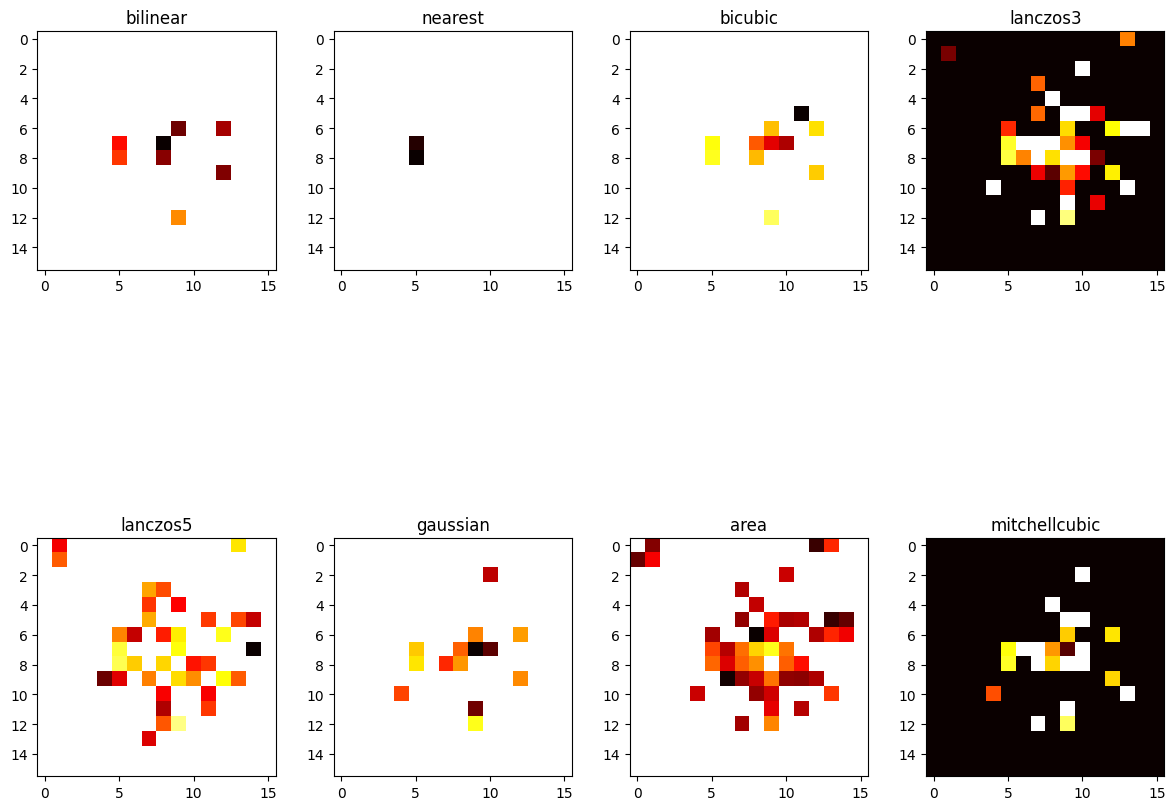

In [145]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Simulación de datos para el ejemplo
sample_data = x_red[5]
methods = ["bilinear", "nearest", "bicubic", "lanczos3", "lanczos5", "gaussian", "area", "mitchellcubic"]
channel = 1
scale = 16

# Crear la figura y los ejes para una cuadrícula de 4x2
fig, axs = plt.subplots(2, 4, figsize=(12, 12))

# Desactivar los ejes no utilizados
for ax in axs.flat:
    ax.set_visible(False)

# Graficar los métodos de reducción
for idx, method in enumerate(methods):
    row, col = divmod(idx, 4)
    cropped = tf.image.central_crop(sample_data[:, :, channel].reshape(125, 125, 1), 0.8)
    reduced_sample = tf.image.resize(cropped, (scale, scale), method=method).numpy()

    axs[row, col].imshow(reduced_sample, cmap="hot", norm=mcolors.LogNorm())
    axs[row, col].set_title(method)
    axs[row, col].set_visible(True)


# Ajustar el layout
fig.tight_layout()
plt.show()


The sparsity in these methods can be enlisted as follows (from less to greater sparsity):
1. neareast
2. bilinear
3. bicubic
4. gaussian
5. mitchellcubic
6. lanczos3
7. lanczos5
8. area


Let's focus on bilinear, lanczos3, lanczos5, and gaussian.

The different methods that can be used to reduce the dimension.
Usually cropping first and then resizing should be the best.

Fix some settings:

- batch size: how many samples to load into memory at once
- file name: name of output file
- output shape: shape the rescale images should have
- channel: which channel to use (in this case only ecal) - you could also rewrite to use all channels
- crop fraction: To what percent to crop down before rescaling

In [93]:
def crop_and_resize(images, channel, scale, crop_fraction=0.8, method='bilinear'):
    cropped_images = tf.image.central_crop(images[:, :, :, channel].reshape(-1, images.shape[1], images.shape[2], 1), crop_fraction)
    resized_images = tf.image.resize(cropped_images, (scale, scale), method=method).numpy()
    return resized_images

def process_and_save_data(x_data, y_data, batch_size, crop_fraction, method, output_shape, channel, file_name):
    n_data = x_data.shape[0]
    num_batches = n_data // batch_size
    events = num_batches * batch_size

    # Limitar los datos a un múltiplo del batch_size
    x_data = x_data[:events]
    y_data = y_data[:events]

    fnew = h5py.File(file_name, "w")
    dsetx = fnew.create_dataset("X", (events,) + output_shape, dtype='f')
    dsety = fnew.create_dataset("y", (events,), dtype='i')

    for i in range(num_batches):
        y_batch = y_data[i * batch_size: (i + 1) * batch_size]
        x_batch = x_data[i * batch_size: (i + 1) * batch_size]

        x_small = crop_and_resize(x_batch, channel, output_shape[0], crop_fraction=crop_fraction, method=method)

        # Normalizar las imágenes
        div1 = np.max(x_small, axis=(1, 2)).reshape((x_batch.shape[0], 1, 1, 1))
        div1[div1 == 0] = 1
        x_small = x_small / div1

        dsety[i * batch_size: (i + 1) * batch_size] = y_batch
        dsetx[i * batch_size: (i + 1) * batch_size] = x_small.reshape((x_small.shape[0],) + output_shape)
        print("Batch ", i, "/", num_batches, end="\r")

    fnew.close()

In [104]:
methods = ["bilinear", "lanczos3", "gaussian", "area", "lanczos5"]
channel = ["tracker", "ECAL", "HCAL"]
output_shape = (16,16,1)

for meth in methods:
  for ch in range(3):
    process_and_save_data(
        x_data=x_red,
        y_data=y_red,
        batch_size=500,
        crop_fraction=0.8,
        method= meth,
        output_shape=output_shape,
        channel= ch,  # 0 = HCAL, 1 = ECAL, 2 = Tracker
        file_name= "QG" + "-" + meth + "-" + channel[ch] + "-" + str(output_shape)
    )

# visualizations

In [188]:
import pandas as pd

def plot_mean_pixel_distribution(x_data, y_data, channel=1, image_shape=(16, 16), figsize=(25, 18)):
    """
    Plots the mean pixel distribution for quark and gluon data.

    Parameters:
    - x_data: numpy array of images.
    - y_data: numpy array of labels.
    - channel: channel to use for the data (default is 1 for ECAL).
    - image_shape: shape of the images (default is (16, 16)).
    - figsize: size of the figure (default is (25, 18)).
    """
    plt.figure(figsize=figsize)

    # Split quark and gluon data
    quark = x_data[np.array(y_data) == 1]
    gluon = x_data[np.array(y_data) == 0]
    channels =["tracker", "ECAL", "HCAL"]

    # Flatten the data
    quark_flat = np.array([img.reshape(np.prod(image_shape)) for img in quark])
    gluon_flat = np.array([img.reshape(np.prod(image_shape)) for img in gluon])

    # Calculate the mean value per pixel in each kind of data
    average_quark_pixel_values = np.mean(quark_flat, axis=0)
    average_gluon_pixel_values = np.mean(gluon_flat, axis=0)

    # Create a dataframe with the mean values for gluon and quark data and a list with all the pixels
    df = {"pixel": np.arange(np.prod(image_shape)),
          "quark_value": average_quark_pixel_values,
          "gluon_value": average_gluon_pixel_values}
    df = pd.DataFrame(df)

    # Plot the distributions
    plt.plot(df["pixel"], df["quark_value"], label="quark pixel distribution")
    plt.plot(df["pixel"], df["gluon_value"], label="gluon pixel distribution")

    plt.xlabel('Pixel location')
    plt.ylabel('Intensity')
    plt.title(f'Mean pixel distribution for quark-gluon data. Channel {channels[channel]}')
    plt.legend()
    plt.show()

    print(f"absolute difference between mean quark and gluon distributions: {(np.abs(average_quark_pixel_values) - np.abs(average_gluon_pixel_values)).sum()}")

In [189]:
def process_and_plot_h5py_data(file_path, channel, method, figsize=(14, 10)):
    """
    Process and plot data from an HDF5 file.

    Parameters:
    - file_path: path to the HDF5 file.
    - channel: channel to use for the data.
    - method: method name for the title.
    - figsize: size of the figure for the pixel distribution plot (default is (15, 10)).
    """
    # Open HDF5 file and read data
    with h5py.File(file_path, "r") as f:
        x_data = f['X'][:]
        y_data = f['y'][:]

    # Plot a single sample
    plt.figure()
    plt.imshow(x_data[0], cmap='viridis', norm=LogNorm())
    plt.title(f"Data Sample. Channel {channel}. {method} method")
    plt.colorbar()
    plt.show()

    # Plot mean pixel distribution
    plot_mean_pixel_distribution(x_data=x_data, y_data=y_data, channel=channel, figsize=figsize)

    # Plot average images for gluons and quarks
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    im1 = axs[0].imshow(np.average(x_data[y_data == 0], axis=0), norm=LogNorm(), cmap='inferno')
    axs[0].title.set_text('Gluon')
    cbar1 = fig.colorbar(im1, ax=axs[0])
    cbar1.ax.set_ylabel('Intensity')

    im2 = axs[1].imshow(np.average(x_data[y_data == 1], axis=0), norm=LogNorm(), cmap='inferno')
    axs[1].title.set_text('Quark')
    cbar2 = fig.colorbar(im2, ax=axs[1])
    cbar2.ax.set_ylabel('Intensity')

    fig.tight_layout()
    plt.show()

    f.close()

## bilinear

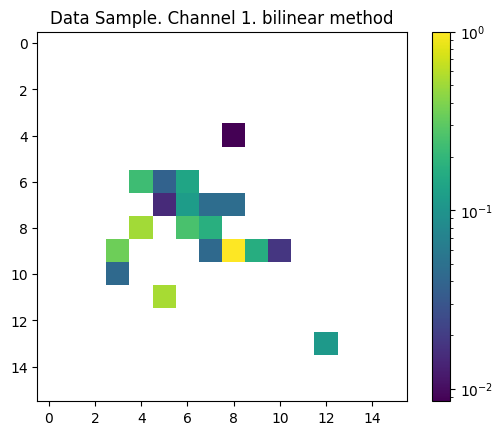

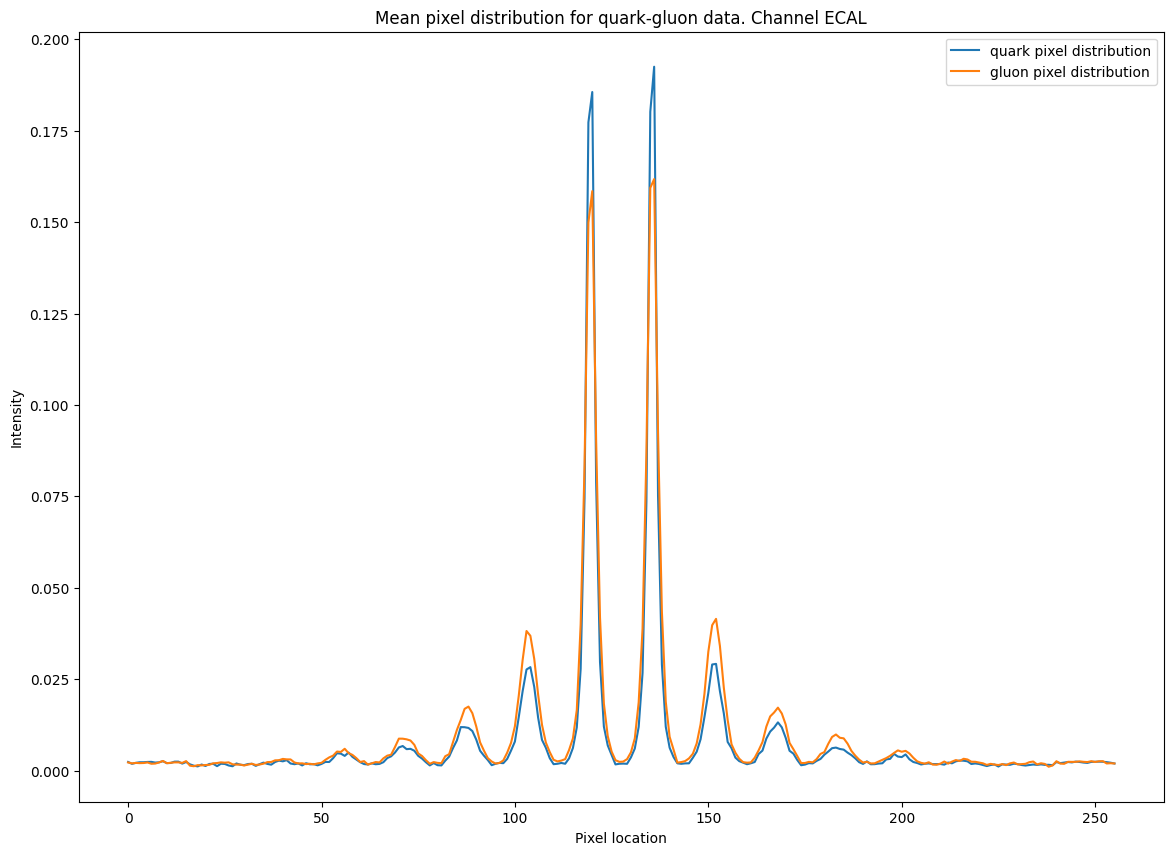

mean square difference between mean quark and gluon: -0.3306053578853607


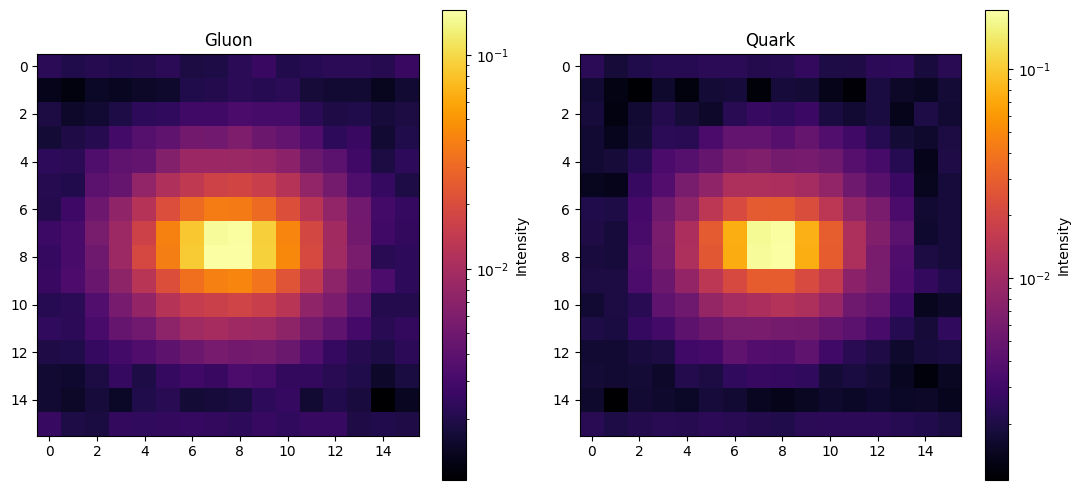

In [190]:
path = "/content/QG-bilinear-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "bilinear" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

## Gaussian

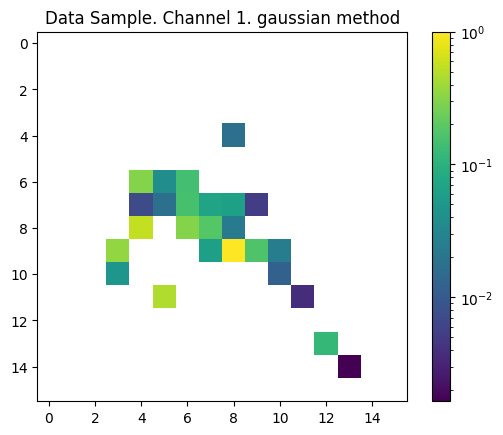

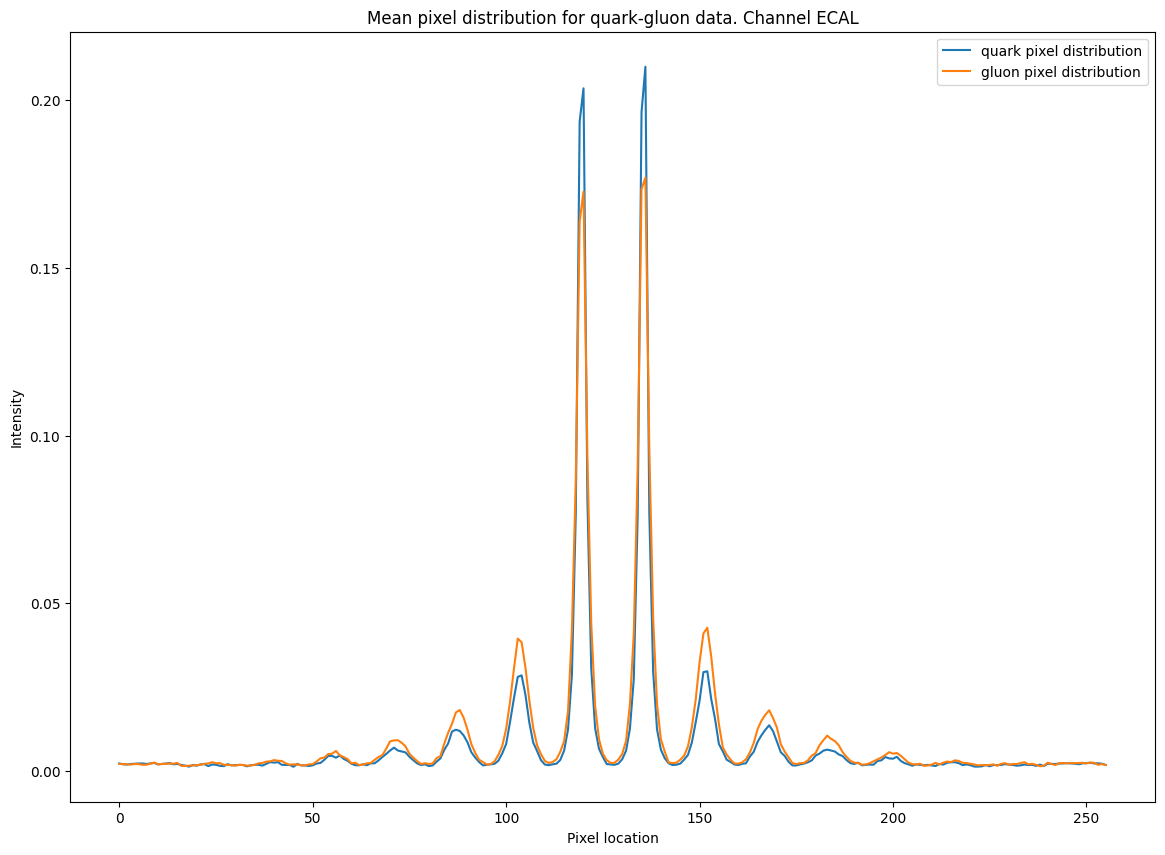

mean square difference between mean quark and gluon: -0.35782983899116516


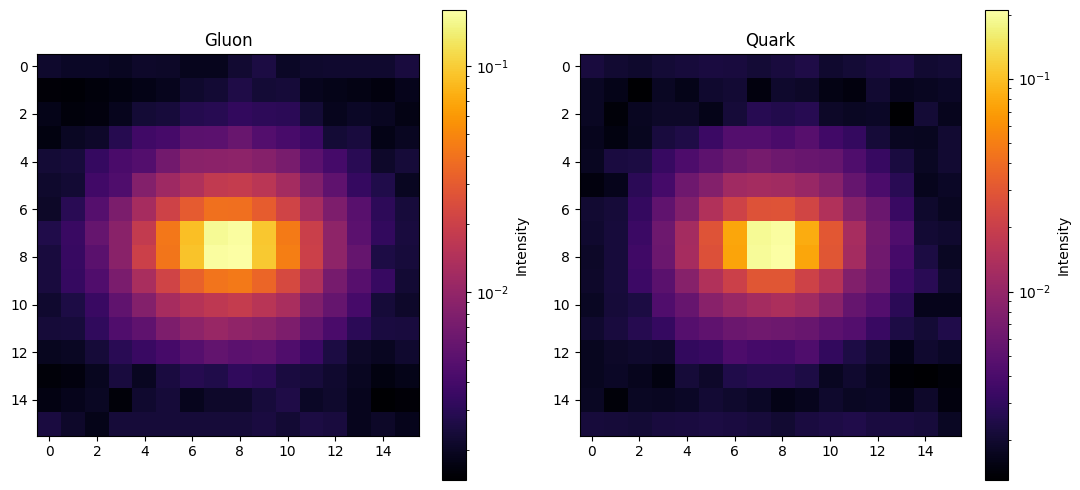

In [191]:
file_path = "/content/QG-gaussian-ECAL-(16, 16, 1)"
channel = 1
method = "gaussian"

process_and_plot_h5py_data(file_path=file_path, channel=channel, method=method)

## lanczos3

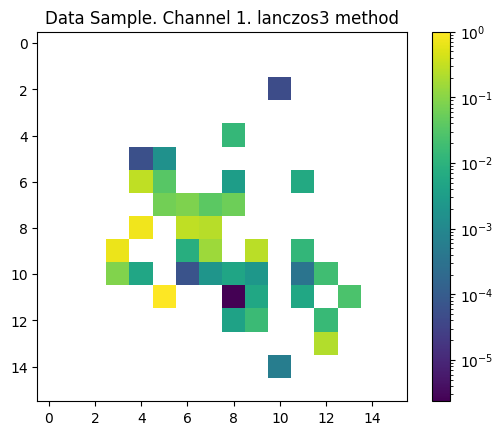

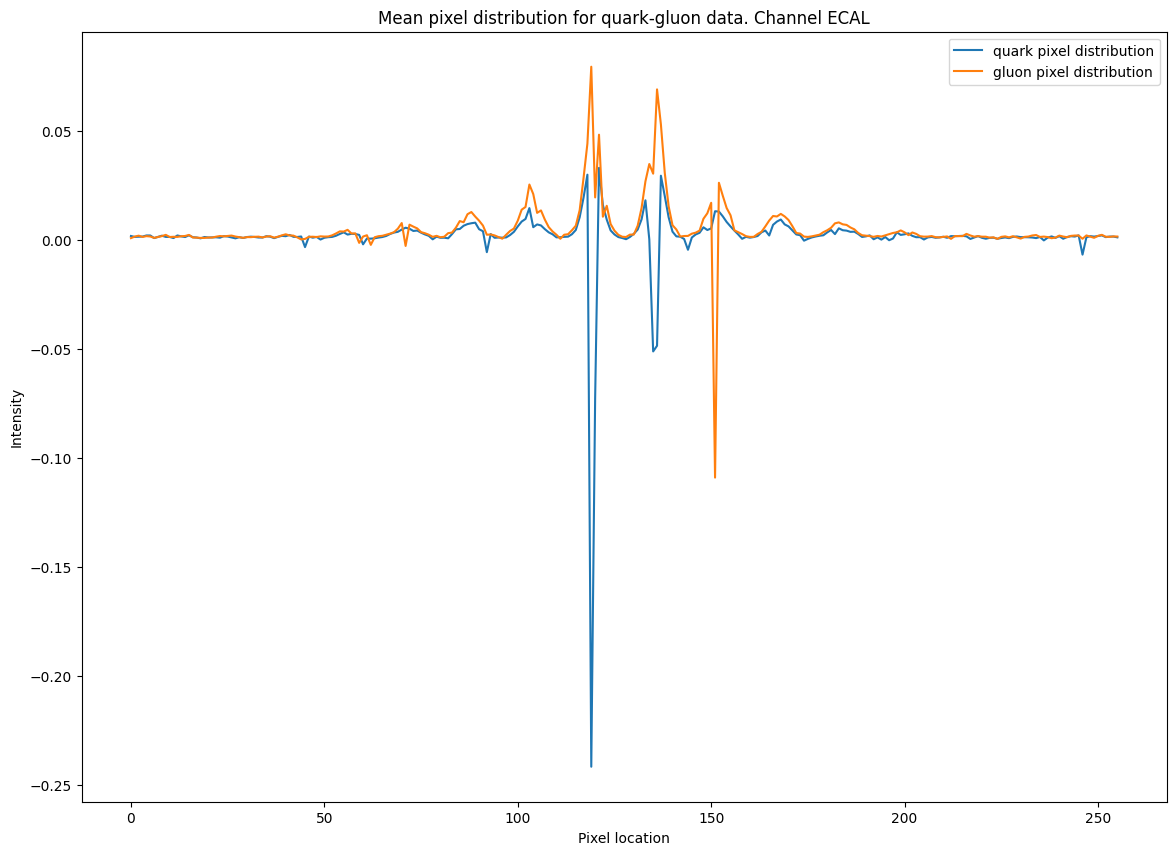

mean square difference between mean quark and gluon: -0.2849452495574951


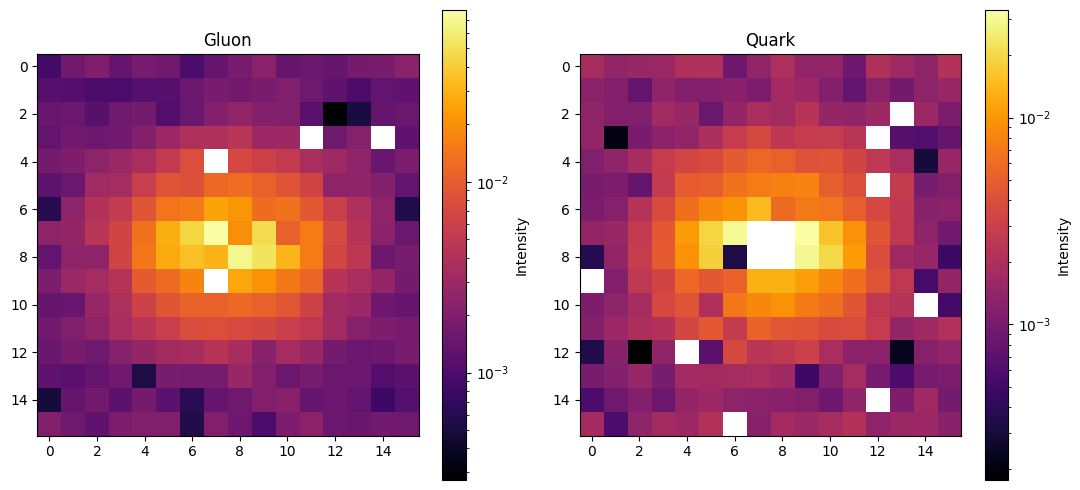

In [192]:
path = "/content/QG-lanczos3-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "lanczos3" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

## lanczos5

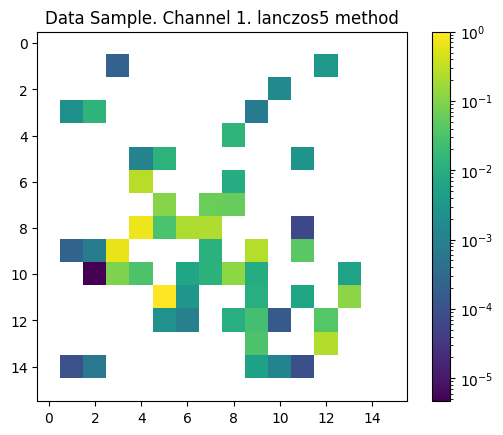

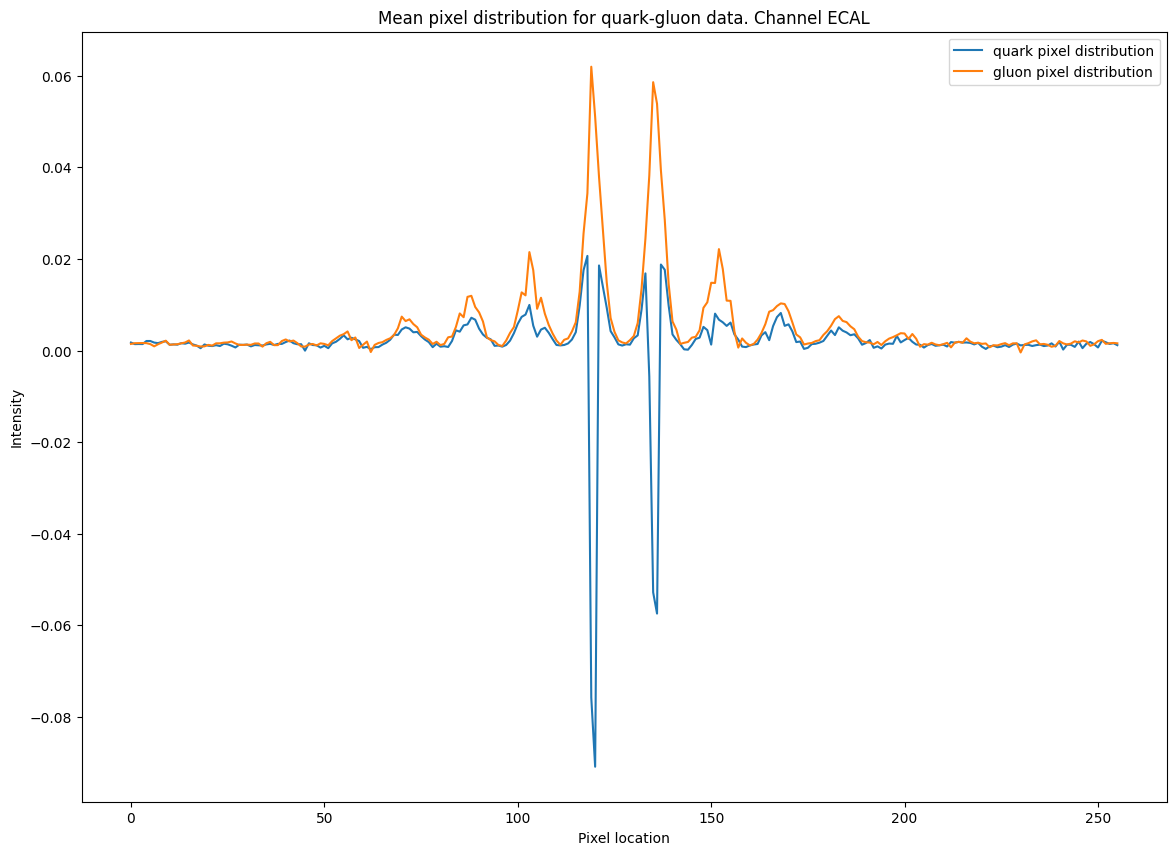

mean square difference between mean quark and gluon: -0.3844860792160034


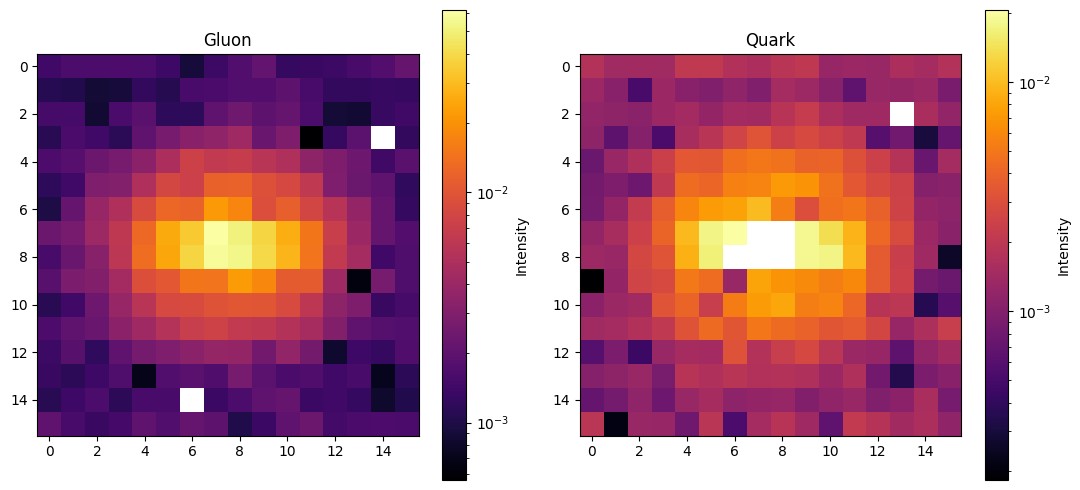

In [193]:
path = "/content/QG-lanczos5-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "lanczos5" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

## area

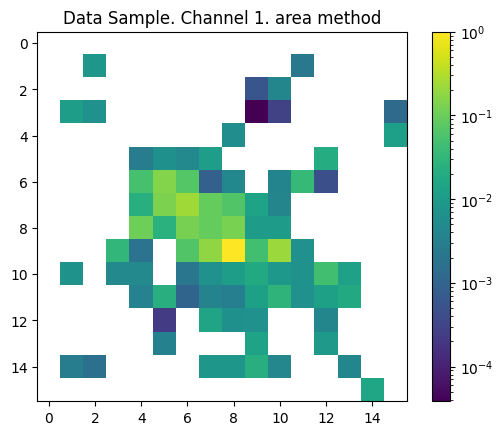

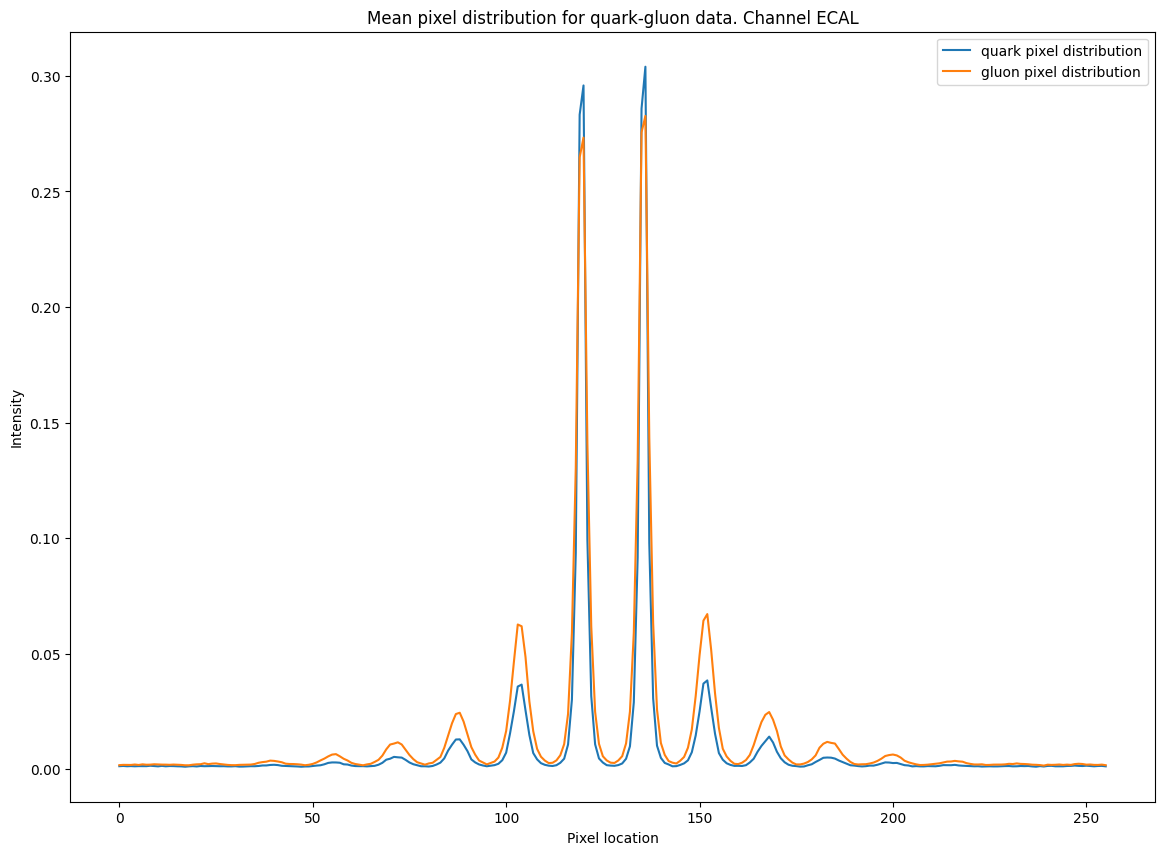

mean square difference between mean quark and gluon: -1.0783467292785645


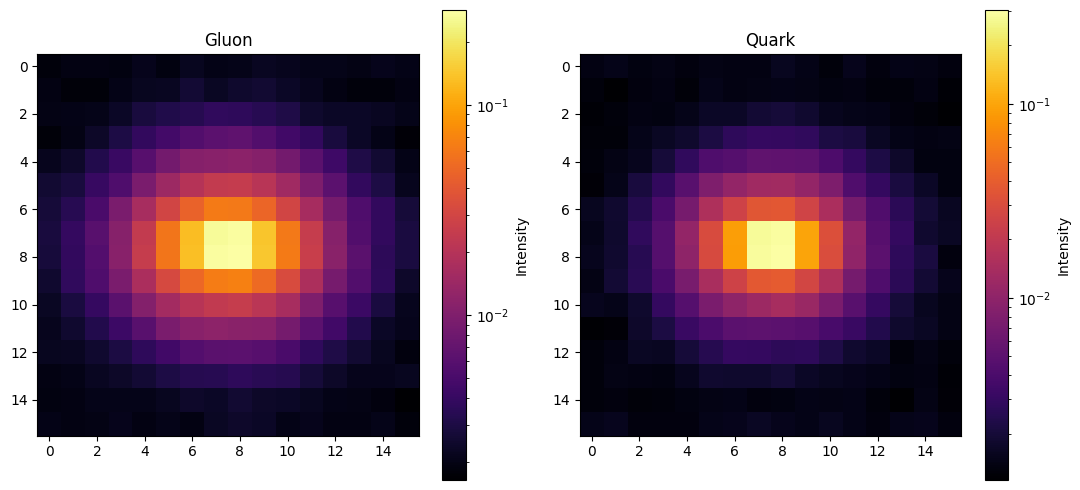

In [194]:
path = "/content/QG-area-ECAL-(16, 16, 1)"
channel = 1 # 0 for tracker, 1 for ECAL, and 2 for HCAL
method = "area" # ["area", "bilinear", "gaussian", "lanczos3", "lanczos5"]

process_and_plot_h5py_data(file_path=path, channel=channel, method=method)

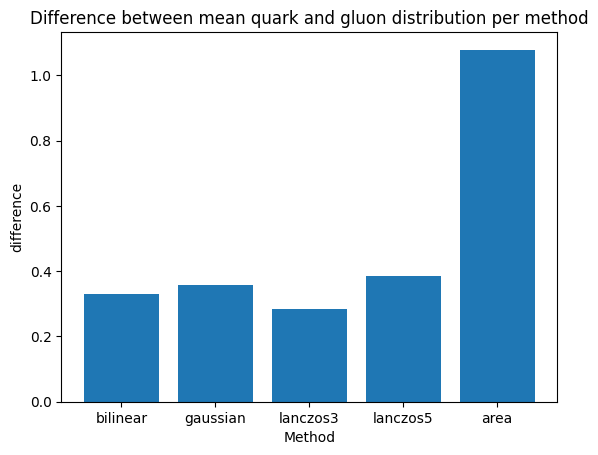

In [200]:
diff_dist_ECAL = {"bilinear": 0.3306053578853607,
            "gaussian": 0.35782983899116516,
            "lanczos3":  0.2849452495574951,
            "lanczos5": 0.3844860792160034,
            "area": 1.0783467292785645,
}

plt.bar(diff_dist_ECAL.keys(), diff_dist_ECAL.values())
plt.xlabel("Method")
plt.ylabel("difference")
plt.title("Difference between mean quark and gluon distribution per method")
plt.show()

As we can see, it seems like using area method is more remarkable the difference between quark and gluon distributions.

In [201]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [207]:
methods = ["bilinear", "lanczos3", "gaussian", "area", "lanczos5"]
channel = ["tracker", "ECAL", "HCAL"]
output_shape = (16,16,1)

for meth in methods:
  for ch in range(3):
   file_name= "/content/" + "QG" + "-" + meth + "-" + channel[ch] + "-" + str(output_shape)
   drive_path = '/content/drive/MyDrive/QG-resize/' + "QG" + "-" + meth + "-" + channel[ch] + "-" + str(output_shape) + ".h5py"
   with h5py.File(drive_path, 'w') as f:
    with h5py.File(file_name, "r") as f0:
      x_data = f0['X'][:]
      y_data = f0['y'][:]
      # Crear datasets en el archivo HDF5
    f.create_dataset('X', data=x_data)
    f.create_dataset('y', data=y_data)

    print(f"Saved file in {drive_path}")

Archivo guardado en /content/drive/MyDrive/QG-resize/QG-bilinear-tracker-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-bilinear-ECAL-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-bilinear-HCAL-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-lanczos3-tracker-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-lanczos3-ECAL-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-lanczos3-HCAL-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-gaussian-tracker-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-gaussian-ECAL-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-gaussian-HCAL-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-area-tracker-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDrive/QG-resize/QG-area-ECAL-(16, 16, 1).h5py
Archivo guardado en /content/drive/MyDr

In [208]:
# example of load data from drive
#drive_path = '/content/drive/MyDrive/QG-resize/QG-area-ECAL-(16, 16, 1).h5py'

#with h5py.File(drive_path, "r") as f0:
#  x_data = f0['X'][:]
#  y_data = f0['y'][:]

#x_data.shape, y_data.shape

((50000, 16, 16, 1), (50000,))